In [8]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("https://datahack2020dataset.s3.us-east-2.amazonaws.com/OfficialCompetitionDataset.csv")
data.pop('Unnamed: 0')

print(f'data dimensions: {data.shape}')

data dimensions: (26504, 25)


Utility functions and symbols

In [24]:
TIME = 'song_debut'
PLAYS = 'nplays'
VULGAR = 'vulgar'

def extract_year_from_date(df):
  df = df.copy()
  df[TIME] = df[TIME].str.slice(0,4)
  df[TIME] = df[TIME].astype('int64')
  return df

def group_by_year(df):
  df = df.copy()

  for i in range(1960,2000,10):
    df.loc[(df[TIME] >= i) & (df[TIME] < i+10),TIME] = i

  df.loc[(df[TIME] >= 2016),TIME] = 2016
  return df

def popularize_in_place(df):
  grouped = df.groupby(TIME)
  thresholds = grouped.quantile(q = 0.90)[PLAYS].values
  years = np.sort(df[TIME].unique())
  df['popular'] = 0

  for year, th in zip(years, thresholds):
    df.loc[(df[TIME] == year) & (df[PLAYS] >= th),'popular'] = 1

In [10]:
data = extract_year_from_date(data)

In [11]:
data = data[data[TIME] != 1952]

In [12]:
data = group_by_year(data)

In [13]:
data[TIME].value_counts()

2006    2021
2008    1867
2007    1844
2005    1805
2013    1761
2009    1698
2016    1653
2010    1582
2011    1569
2014    1546
2003    1490
2004    1354
2002    1204
2015    1173
2012    1166
2001     966
1990     663
2000     628
1970     239
1980     160
1960     106
Name: song_debut, dtype: int64

In [14]:
years = data[TIME].unique()
print(years)
counts = data[TIME].value_counts()[years].values

[2007 2003 2005 2014 2004 2010 2009 2012 2000 2011 2008 2002 2006 2013
 2001 2015 1970 2016 1990 1960 1980]


Plot the number of songs for the given bins.

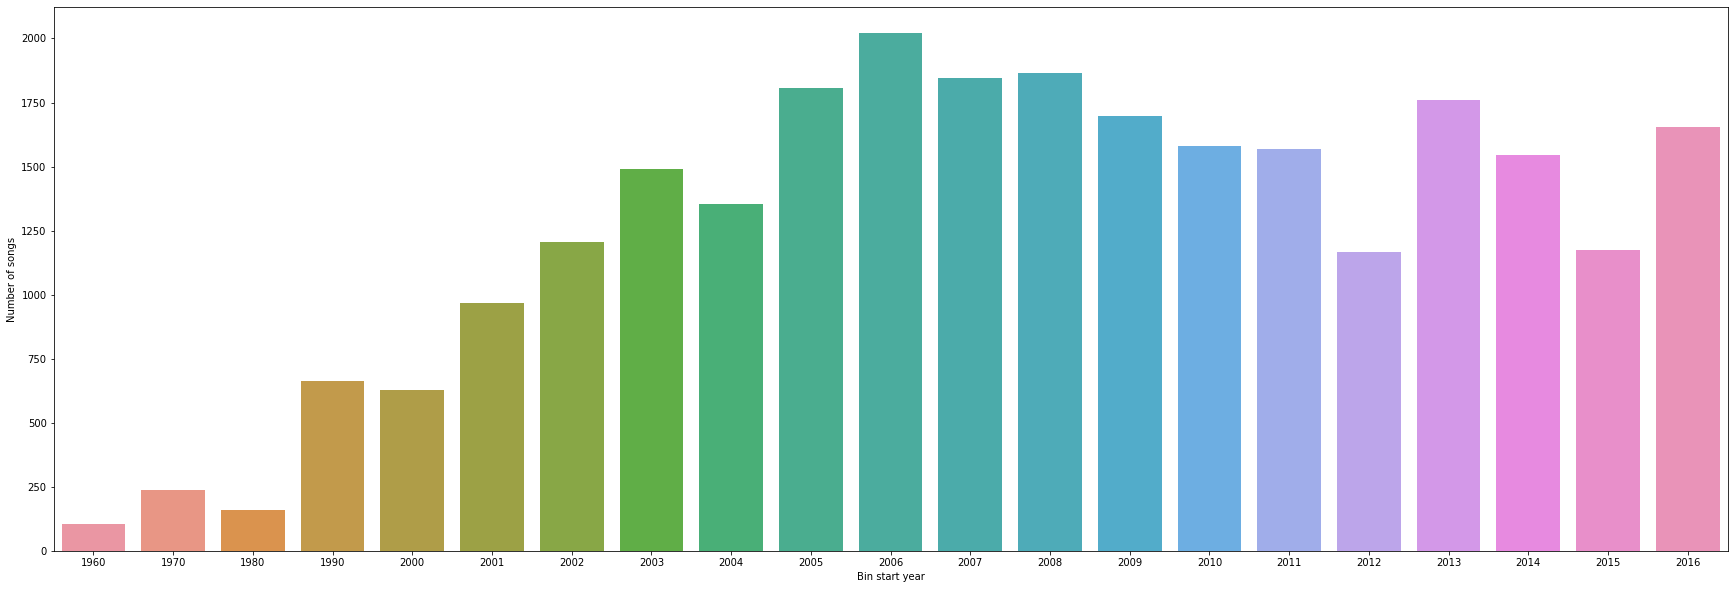

In [15]:
plt.figure(figsize=(30,10))
sns.barplot(x=years, y=counts); plt.xlabel('Bin start year'); plt.ylabel('Number of songs');

In [18]:
data_drop = data.drop(columns = ['name','album', 'artist', 'critic','critic_rating','review','reviewer_type'])

In [25]:
popularize_in_place(data_drop)

In [26]:
data_drop['popular'].value_counts()

0    23835
1     2660
Name: popular, dtype: int64

In [27]:
data_drop.to_csv('altered.csv')

Use song qualities to train a categorical boosting model that predicts the popularity of a song. This allows us to extract the important features that determine the popularity of any given song.

In [28]:
X = data_drop.drop(columns = ['nplays','popular','hotness'])
y = data_drop['popular']

In [29]:
X['styles'] = X['styles'].fillna('None')
X.isna().any()

auditory               False
beats_per_measure      False
beats_per_min          False
concert_probability    False
danceability           False
hype                   False
instrumentalness       False
length_minutes         False
lyricism               False
major/minor            False
positivity             False
song_debut             False
styles                 False
tone                   False
volume                 False
vulgar                 False
dtype: bool

In [ ]:
cat_features = ['beats_per_measure','major/minor','styles','tone','vulgar']
X['beats_per_measure'] = X['beats_per_measure'].astype("int64")

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
cb = CatBoostClassifier(eval_metric= 'AUC')
cb.fit(X_train,y_train, eval_set = (X_test,y_test), cat_features=cat_features)

Learning rate set to 0.066309
0:	test: 0.5379946	best: 0.5379946 (0)	total: 33.3ms	remaining: 33.3s
1:	test: 0.6331921	best: 0.6331921 (1)	total: 66.1ms	remaining: 33s
2:	test: 0.6511641	best: 0.6511641 (2)	total: 101ms	remaining: 33.6s
3:	test: 0.6619318	best: 0.6619318 (3)	total: 134ms	remaining: 33.3s
4:	test: 0.6693931	best: 0.6693931 (4)	total: 176ms	remaining: 35.1s
5:	test: 0.6757022	best: 0.6757022 (5)	total: 216ms	remaining: 35.8s
6:	test: 0.6804569	best: 0.6804569 (6)	total: 253ms	remaining: 35.9s
7:	test: 0.6835787	best: 0.6835787 (7)	total: 291ms	remaining: 36.1s
8:	test: 0.6824198	best: 0.6835787 (7)	total: 326ms	remaining: 35.9s
9:	test: 0.6835142	best: 0.6835787 (7)	total: 354ms	remaining: 35.1s
10:	test: 0.6881883	best: 0.6881883 (10)	total: 368ms	remaining: 33.1s
11:	test: 0.6880524	best: 0.6881883 (10)	total: 402ms	remaining: 33.1s
12:	test: 0.6882516	best: 0.6882516 (12)	total: 424ms	remaining: 32.2s
13:	test: 0.6889507	best: 0.6889507 (13)	total: 442ms	remaining: 31

The importance of each song quality, as identified by the ML model.

In [ ]:
feature_importance_df = cb.get_feature_importance(prettified=True)
feature_importance_df

,Feature Id,Importances
0,styles,11.750898
1,length_minutes,10.131188
2,song_debut,9.358971
3,danceability,9.017534
4,volume,8.205589
5,instrumentalness,7.659529
6,auditory,6.962362
7,beats_per_min,6.947553
8,hype,6.851323
9,positivity,6.547251


Repeat the above procedure but only for songs released prior to 2000.

In [ ]:
X_pre = X[X['song_debut'] < 2000]
y_pre = y[X['song_debut'] < 2000]
X_pre.columns.values

array(['auditory', 'beats_per_measure', 'beats_per_min',
       'concert_probability', 'danceability', 'hype', 'instrumentalness',
       'length_minutes', 'lyricism', 'major/minor', 'positivity',
       'song_debut', 'styles', 'tone', 'volume', 'vulgar'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X_pre, y_pre)
cb = CatBoostClassifier(eval_metric= 'AUC')
cb.fit(X_train,y_train, eval_set = (X_test,y_test), cat_features=cat_features)

Learning rate set to 0.03067
0:	test: 0.5692135	best: 0.5692135 (0)	total: 7.64ms	remaining: 7.63s
1:	test: 0.6519101	best: 0.6519101 (1)	total: 13.9ms	remaining: 6.93s
2:	test: 0.6740075	best: 0.6740075 (2)	total: 19.4ms	remaining: 6.46s
3:	test: 0.6684644	best: 0.6740075 (2)	total: 21.5ms	remaining: 5.35s
4:	test: 0.6751311	best: 0.6751311 (4)	total: 27.4ms	remaining: 5.45s
5:	test: 0.6748315	best: 0.6751311 (4)	total: 33ms	remaining: 5.47s
6:	test: 0.7085393	best: 0.7085393 (6)	total: 39.5ms	remaining: 5.61s
7:	test: 0.7297378	best: 0.7297378 (7)	total: 42.1ms	remaining: 5.22s
8:	test: 0.7477154	best: 0.7477154 (8)	total: 48.3ms	remaining: 5.32s
9:	test: 0.7399251	best: 0.7477154 (8)	total: 54.4ms	remaining: 5.38s
10:	test: 0.7360300	best: 0.7477154 (8)	total: 61.1ms	remaining: 5.49s
11:	test: 0.7361798	best: 0.7477154 (8)	total: 63.4ms	remaining: 5.22s
12:	test: 0.7274906	best: 0.7477154 (8)	total: 69.6ms	remaining: 5.29s
13:	test: 0.7261423	best: 0.7477154 (8)	total: 71.7ms	remain

In [ ]:
feature_importance_df = cb.get_feature_importance(prettified=True)
feature_importance_df

,Feature Id,Importances
0,styles,13.630622
1,song_debut,10.545412
2,volume,8.725316
3,length_minutes,8.509577
4,concert_probability,7.075056
5,lyricism,7.058976
6,beats_per_measure,6.918114
7,hype,6.033424
8,danceability,5.390472
9,beats_per_min,5.377289


Repeat the above procedure but for songs released 2000 and beyond.

In [ ]:
X_post = X[X['song_debut'] >= 2000]
y_post = y[X['song_debut'] >= 2000]
X_post.columns.values

array(['auditory', 'beats_per_measure', 'beats_per_min',
       'concert_probability', 'danceability', 'hype', 'instrumentalness',
       'length_minutes', 'lyricism', 'major/minor', 'positivity',
       'song_debut', 'styles', 'tone', 'volume', 'vulgar'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X_post, y_post)
cb = CatBoostClassifier(eval_metric= 'AUC')
cb.fit(X_train,y_train, eval_set = (X_test,y_test), cat_features=cat_features)

Learning rate set to 0.065574
0:	test: 0.6272052	best: 0.6272052 (0)	total: 36.4ms	remaining: 36.4s
1:	test: 0.6247221	best: 0.6272052 (0)	total: 75ms	remaining: 37.4s
2:	test: 0.6308457	best: 0.6308457 (2)	total: 105ms	remaining: 34.9s
3:	test: 0.6453039	best: 0.6453039 (3)	total: 155ms	remaining: 38.5s
4:	test: 0.6476652	best: 0.6476652 (4)	total: 179ms	remaining: 35.6s
5:	test: 0.6495632	best: 0.6495632 (5)	total: 227ms	remaining: 37.6s
6:	test: 0.6524623	best: 0.6524623 (6)	total: 260ms	remaining: 36.9s
7:	test: 0.6655943	best: 0.6655943 (7)	total: 292ms	remaining: 36.2s
8:	test: 0.6705104	best: 0.6705104 (8)	total: 332ms	remaining: 36.5s
9:	test: 0.6711261	best: 0.6711261 (9)	total: 381ms	remaining: 37.7s
10:	test: 0.6771874	best: 0.6771874 (10)	total: 422ms	remaining: 37.9s
11:	test: 0.6772686	best: 0.6772686 (11)	total: 461ms	remaining: 37.9s
12:	test: 0.6758691	best: 0.6772686 (11)	total: 487ms	remaining: 37s
13:	test: 0.6800683	best: 0.6800683 (13)	total: 522ms	remaining: 36.7

In [ ]:
feature_importance_df = cb.get_feature_importance(prettified=True)
feature_importance_df

,Feature Id,Importances
0,styles,10.433779
1,length_minutes,9.551440
2,song_debut,9.160299
3,danceability,9.151817
4,volume,8.048298
5,beats_per_min,7.648410
6,auditory,7.642635
7,instrumentalness,7.611871
8,positivity,7.392156
9,hype,6.787885
